# Overview

* Typical diagnostic tools and visualizations of deep network
* Batch normalization
* Residual connections
* Adam optimizer

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
from torch.utils.tensorboard import SummaryWriter

2024-07-27 04:27:07.290423: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-27 04:27:07.290573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-27 04:27:07.450540: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load dataset

In [2]:
# read in all the words
with open('/kaggle/input/character-lm-without-framework/names.txt', 'r', encoding='utf-8') as f:
    words=f.read()

words=words.splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

# Build vocabulary of characters

In [4]:
# build the vocabulary of characters and 
chars=sorted(list(set(''.join(words))))

# Mappings to/from integers

In [5]:
stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
vocab_size=len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


# Build the dataset

In [6]:
import random

block_size=3 # context length: how many characters do we take to predict the next one?
writer=SummaryWriter()

def build_dataset(words):
    X,Y=[],[]
    
    for w in words:
        context=[0]*block_size
        for ch in w+'.':
            ix=stoi[ch]
            X.append(context)
            Y.append(ix)
            context=context[1:]+[ix] # crop and append
            
    X=torch.tensor(X)
    Y=torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

Xtr, Ytr=build_dataset(words[:n1])     # 80%
Xdev, Ydev=build_dataset(words[n1:n2]) # 10%
Xte, Yte=build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# MLP

In [7]:
n_embd=10 # the dimensionality of the character embedding vectors
n_hidden=200 # the number of neurons in the hidden layer of the MLP

g=torch.Generator().manual_seed(2147483647) # for reproducibility
C=torch.randn((vocab_size, n_embd),           generator=g)
W1=torch.randn((n_embd*block_size, n_hidden), generator=g)
b1=torch.randn(n_hidden,                      generator=g)
W2=torch.randn((n_hidden, vocab_size),        generator=g)
b2=torch.randn(vocab_size,                    generator=g)

parameters=[C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad=True

11897


In [8]:
max_steps=200000
batch_size=32
lossi=[]

for i in range(max_steps):
    # minibatch construct
    ix=torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb,Yb=Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb=C[Xb] # embed the characters into vectors
    embcat=emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact=embcat@W1+b1 # hidden layer pre-activation
    h=torch.tanh(hpreact) # hidden layer
    logits=h@W2+b2 # output layer
    loss=F.cross_entropy(logits, Yb) # loss function
    writer.add_scalar("Loss/train", loss, i)
    
    # backward pass
    for p in parameters:
        p.grad=None
    loss.backward()
    
    # update
    lr=0.1 if i< 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data+=-lr*p.grad
    
    # track stats
    if i%10000 ==0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

writer.flush()
writer.close()

      0/ 200000: 27.8817
  10000/ 200000: 2.9571
  20000/ 200000: 2.5722
  30000/ 200000: 2.7646
  40000/ 200000: 2.0305
  50000/ 200000: 2.5794
  60000/ 200000: 2.3242
  70000/ 200000: 2.1174
  80000/ 200000: 2.2993
  90000/ 200000: 2.2481
 100000/ 200000: 2.0146
 110000/ 200000: 2.4534
 120000/ 200000: 1.9164
 130000/ 200000: 2.3719
 140000/ 200000: 2.2377
 150000/ 200000: 2.1441
 160000/ 200000: 2.2661
 170000/ 200000: 1.7855
 180000/ 200000: 2.1126
 190000/ 200000: 1.8004


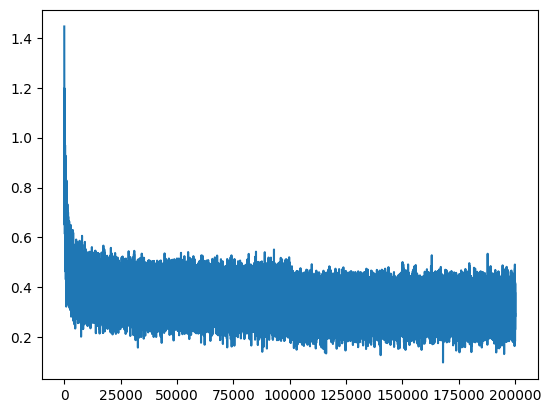

In [9]:
plt.plot(lossi)

# Split the loss

In [10]:
@torch.no_grad()
def split_loss(split):
    x,y={
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb=C[x] # (N, block_size, n_embd)
    embcat=emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h=torch.tanh(embcat @W1+b1) # (N, n_hidden)
    logits=h@W2+b2 #(N, vocab_size)
    loss=F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1270017623901367
val 2.169905662536621


# Sample from the model

In [11]:
g=torch.Generator().manual_seed(2147483647+10)

for _ in range(20):
    out=[]
    context=[0]*block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb=C[torch.tensor([context])] # (1, block_size, n_embd)
        h=torch.tanh(emb.view(1,-1) @ W1+b1)
        logits=h@W2+b2
        probs=F.softmax(logits, dim=1)
        # sample from the distribution
        ix=torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context=context[1:]+[ix]
        out.append(ix)
        if ix==0:
            break
    print(''.join(itos[i] for i in out)) # decode the print and the generated word

mona.
mayah.
seel.
nah.
yam.
ren.
ruchadrael.
adeero.
elin.
shy.
jen.
eden.
eson.
arleigh.
malkia.
noshubergihamies.
kendretzy.
panthona.
uszayven.
kylene.


# Acknowledgement
* https://www.youtube.com/watch?v=P6sfmUTpUmc&t=41s